The network consists of 4 nodes and 4 elements:

| Component | Type            | Python Class                              | Node A | Node B | Paramter |
| :---------| :----           | :---------------------------------------- | :----- | :----- | :------- |
| Vs        | Voltage Source  | `dpsim.dp.ph1.VoltageSource`       | GND    | 1    | 10 kV       |
| R1        | Line Resistance | `dpsim.dp.ph1.Resistor`            | 1      | 2      | 1 Ohm       |
| L1        | Line Inductance | `dpsim.dp.ph1.Inductor`            | 2      | 3      | 0.02 Henry  |
| R2        | Load            | `dpsim.dp.ph1.Resistor`            | 3      | GND    | 10 Ohm      |
| R3        | Load            | `dpsim.dp.ph1.Resistor`            | 3      | 4      | 10 Ohm      |
| S1        | Switch          | `dpsim.dp.ph1.Switch`              | 4      | GND    |             |

![](./Figures/vs_line_load.svg.png)

In [21]:
import villas.dataprocessing.readtools as rt
import villas.dataprocessing.plottools as pt
from villas.dataprocessing.timeseries import TimeSeries as ts
import math
import dpsimpy
import socket
import json

## DPsim DP

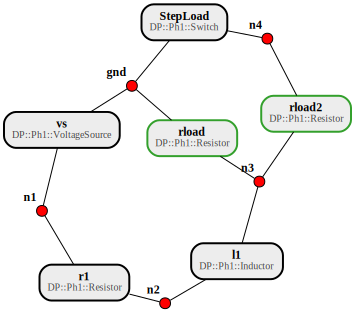

In [22]:
# DPsim DP simulation
name = 'VILLAS_test_DP'
tsim = 0.5
time_step = 0.000001

# Nodes
gnd = dpsimpy.dp.SimNode.gnd
n1 =  dpsimpy.dp.SimNode('n1')
n2 =  dpsimpy.dp.SimNode('n2')
n3 =  dpsimpy.dp.SimNode('n3')
n4 =  dpsimpy.dp.SimNode('n4')

# initialize node voltages as in simulunk
n2.set_initial_voltage(complex(0,0))
n3.set_initial_voltage(complex(0,0))

# Components
vs = dpsimpy.dp.ph1.VoltageSource('vs')
vs.set_parameters(V_ref=complex(10000, 0) * math.sqrt(2))
r1 = dpsimpy.dp.ph1.Resistor('r1')
r1.set_parameters(R=1)
l1 = dpsimpy.dp.ph1.Inductor('l1')
l1.set_parameters(L=0.02)

r2 = dpsimpy.dp.ph1.Resistor('rload')
r2.set_parameters(R=10)
r3 = dpsimpy.dp.ph1.Resistor('rload2')
r3.set_parameters(R=10)

sw = dpsimpy.dp.ph1.Switch('StepLoad', dpsimpy.LogLevel.debug)
sw.set_parameters(1e9, 0.01, False)
sw.open()

vs.connect([gnd, n1])
r1.connect([n2, n1])
l1.connect([n3, n2])
r2.connect([gnd, n3])
r3.connect([n4, n3])
sw.connect([n4, gnd])

system = dpsimpy.SystemTopology(50, [gnd, n1, n2, n3, n4], [vs, r1, l1, r2, r3, sw])

logger = dpsimpy.Logger(name)

system

In [23]:
name = 'VILLAS_test_DP'

dpsimpy.Logger.set_log_dir("logs/" + name)

logger = dpsimpy.Logger(name)

for i in range(1, len(system.nodes)):
    logger.log_attribute("n" + str(i) + ".v", "v", system.nodes[i])
    
logger.log_attribute('r1.i_intf', 'i_intf', r1);
#logger.log_attribute('l1.i_intf', 'i_intf', l1);

sim = dpsimpy.Simulation(name)
sim.set_domain(dpsimpy.Domain.DP)
sim.set_system(system)
sim.set_time_step(time_step)
sim.set_final_time(tsim)

# Events
sw_on = dpsimpy.event.SwitchEvent(0.1, sw, True)
sim.add_event(sw_on)

sw_off = dpsimpy.event.SwitchEvent(0.2, sw, False)
sim.add_event(sw_off)

sim.add_logger(logger)
print(sim)
sim.run()

1.000000e-01: Handle event time
2.000000e-01: Handle event time


[20:23:02.778365 MnaSolverFactory info] creating KLUAdapter solver implementation


In [24]:
# read DPsim DP results
work_dir = "logs/" + name + "/"
log_name = 'VILLAS_test_DP'
print(work_dir + log_name + '.csv')
ts_dpsim_dp = rt.read_timeseries_dpsim(work_dir + log_name + '.csv')

logs/VILLAS_test_DP/VILLAS_test_DP.csv
column number: 5
results length: 500001
real column names: []
complex column names: ['n1.v', 'n2.v', 'n3.v', 'n4.v', 'r1.i_intf']


In [25]:
# convert to emt
ts_dpsim_dp_emt = ts.frequency_shift_list(ts_dpsim_dp, 50)

# 3Ph, RMS to 1Ph 
for name, ts in ts_dpsim_dp_emt.items():
    ts.values = ts.values * math.sqrt(2)/2

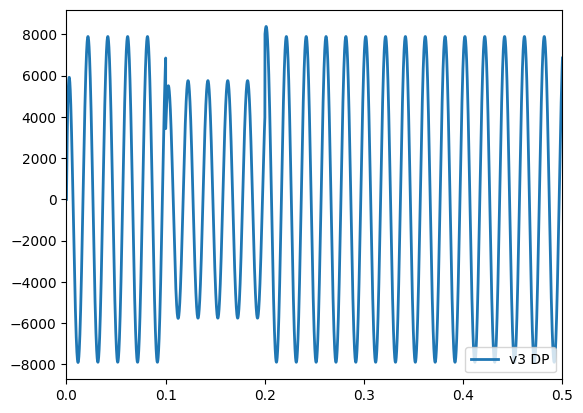

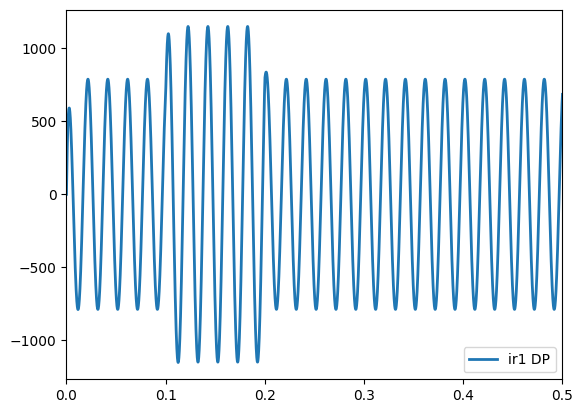

In [26]:
pt.set_timeseries_labels(ts_dpsim_dp_emt['n1.v_shift'], 'v1 DP')
pt.set_timeseries_labels(ts_dpsim_dp_emt['n2.v_shift'], 'v2 DP')
pt.set_timeseries_labels(ts_dpsim_dp_emt['n3.v_shift'], 'v3 DP')
pt.set_timeseries_labels(ts_dpsim_dp_emt['r1.i_intf_shift'], 'ir1 DP')
#pt.plot_timeseries(1, ts_dpsim_dp_emt['n1.v_shift'])
#pt.plot_timeseries(1, ts_dpsim_dp_emt['n2.v_shift'])
pt.plot_timeseries(1, ts_dpsim_dp_emt['n3.v_shift'])
pt.plot_timeseries(2, ts_dpsim_dp_emt['r1.i_intf_shift'])

## DPsim EMT

In [27]:
# EMT simulation
name = 'VILLAS_test_EMT'
dpsimpy.Logger.set_log_dir("logs/" + name)

# Nodes
gnd = dpsimpy.emt.SimNode.gnd
n1 =  dpsimpy.emt.SimNode('n1')
n2 =  dpsimpy.emt.SimNode('n2')
n3 =  dpsimpy.emt.SimNode('n3')
n4 =  dpsimpy.emt.SimNode('n4')

# initialize node voltages as in simulunk
n2.set_initial_voltage(complex(0,0))
n3.set_initial_voltage(complex(0,0))

# Components
vs = dpsimpy.emt.ph1.VoltageSource('vs')
vs.set_parameters(V_ref=complex(10000,0), f_src=50)
r1 = dpsimpy.emt.ph1.Resistor('r1')
r1.set_parameters(R=1)
l1 = dpsimpy.emt.ph1.Inductor('l1')
l1.set_parameters(L=0.02)

r2 = dpsimpy.emt.ph1.Resistor('rload')
r2.set_parameters(R=10)
r3 = dpsimpy.emt.ph1.Resistor('rload2')
r3.set_parameters(R=10)

sw = dpsimpy.emt.ph1.Switch('StepLoad', dpsimpy.LogLevel.debug)
sw.set_parameters(1e9, 0.01, False)
sw.open()

vs.connect([gnd, n1])
r1.connect([n2, n1])
l1.connect([n3, n2])
r2.connect([gnd, n3])
r3.connect([n4, n3])
sw.connect([n4, gnd])


system = dpsimpy.SystemTopology(50, [gnd, n1, n2, n3, n4], [vs, r1, l1, r2, r3, sw])

logger = dpsimpy.Logger(name)

for i in range(1, len(system.nodes)):
    logger.log_attribute("n" + str(i) + ".v", "v", system.nodes[i])

logger.log_attribute('r1.v_intf', 'v_intf', r1)
logger.log_attribute('r1.i_intf', 'i_intf', r1)
logger.log_attribute('l1.v_intf', 'v_intf', l1)
logger.log_attribute('l1.i_intf', 'i_intf', l1)
logger.log_attribute('rload.i_intf', 'i_intf', r2)

sim = dpsimpy.Simulation(name)
sim.add_logger(logger)
sim.set_system(system)
sim.set_domain(dpsimpy.Domain.EMT)
sim.set_time_step(time_step)
sim.set_final_time(tsim)

# Events
sw_on = dpsimpy.event.SwitchEvent(0.1, sw, True)
sim.add_event(sw_on)

sw_off = dpsimpy.event.SwitchEvent(0.2, sw, False)
sim.add_event(sw_off)

sim.run()

1.000000e-01: Handle event time


[20:23:29.689687 MnaSolverFactory info] creating KLUAdapter solver implementation


2.000000e-01: Handle event time


In [28]:
# read EMT results
work_dir = 'logs/VILLAS_test_EMT/'
log_name = 'VILLAS_test_EMT'
print(work_dir + log_name + '.csv')

ts_dpsim_emt = rt.read_timeseries_dpsim(work_dir + log_name + '.csv')

logs/VILLAS_test_EMT/VILLAS_test_EMT.csv
column number: 9
results length: 500001
real column names: ['l1.i_intf', 'l1.v_intf', 'n1.v', 'n2.v', 'n3.v', 'n4.v', 'r1.i_intf', 'r1.v_intf', 'rload.i_intf']
complex column names: []


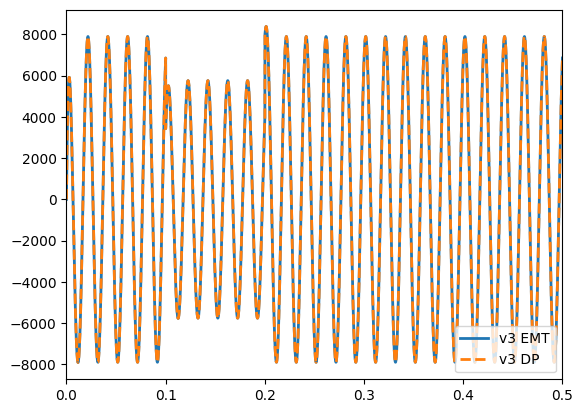

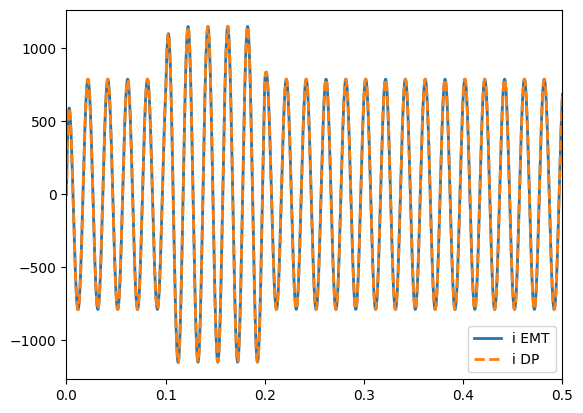

In [29]:
v1 = 'n1.v'
v2 = 'n2.v'
i12 = 'r1.i_intf'

ts_dpsim_emt['n1.v'].label = 'v1 EMT'
ts_dpsim_emt['n2.v'].label = 'v2 EMT'
ts_dpsim_emt['n3.v'].label = 'v3 EMT'
ts_dpsim_dp_emt['n3.v_shift'].label = 'v3 DP'
ts_dpsim_emt['r1.i_intf'].label = 'i EMT'
ts_dpsim_dp_emt['r1.i_intf_shift'].label = 'i DP'

#pt.plot_timeseries(1, ts_dpsim_emt['n1.v'])
#pt.plot_timeseries(1, ts_dpsim_emt['n2.v'])
pt.plot_timeseries(1, ts_dpsim_emt['n3.v'])
pt.plot_timeseries(1, ts_dpsim_dp_emt['n3.v_shift'], plt_linestyle='--',)
pt.plot_timeseries(2, ts_dpsim_emt['r1.i_intf'])
pt.plot_timeseries(2, ts_dpsim_dp_emt['r1.i_intf_shift'], plt_linestyle='--')


In [30]:
# calculate the RMSE between DP and EMT
err_dp_emt = 0
err_dp_emt += ts.rmse(ts_dpsim_dp_emt['n3.v_shift'], ts_dpsim_emt['n3.v'])
err_dp_emt += ts.rmse(ts_dpsim_dp_emt['r1.i_intf_shift'], ts_dpsim_emt['r1.i_intf'])
err_dp_emt = err_dp_emt / 2
print("Total RMSE of DPsim DP reference and DPsim EMT: %g" % (err_dp_emt))

Total RMSE of DPsim DP reference and DPsim EMT: 1.49454e-05
